In [11]:
!pip install torch torchvision tensorboard


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 28.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 30.1 MB/s eta 0:00:0000:01


Using device: cuda

>>> Profiling model: GPT2
Model load time: 0.48 seconds
Model parameters: 124,439,808
Model size: 474.70 MB
Generated text: The future of artificial intelligence in medicine is uncertain.

"We're not sure what the future of artificial intelligence in medicine will be,"
Generation time: 4.2783 seconds
Tokens per second: 4.67
CUDA memory used: 4.96 MB
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  -----

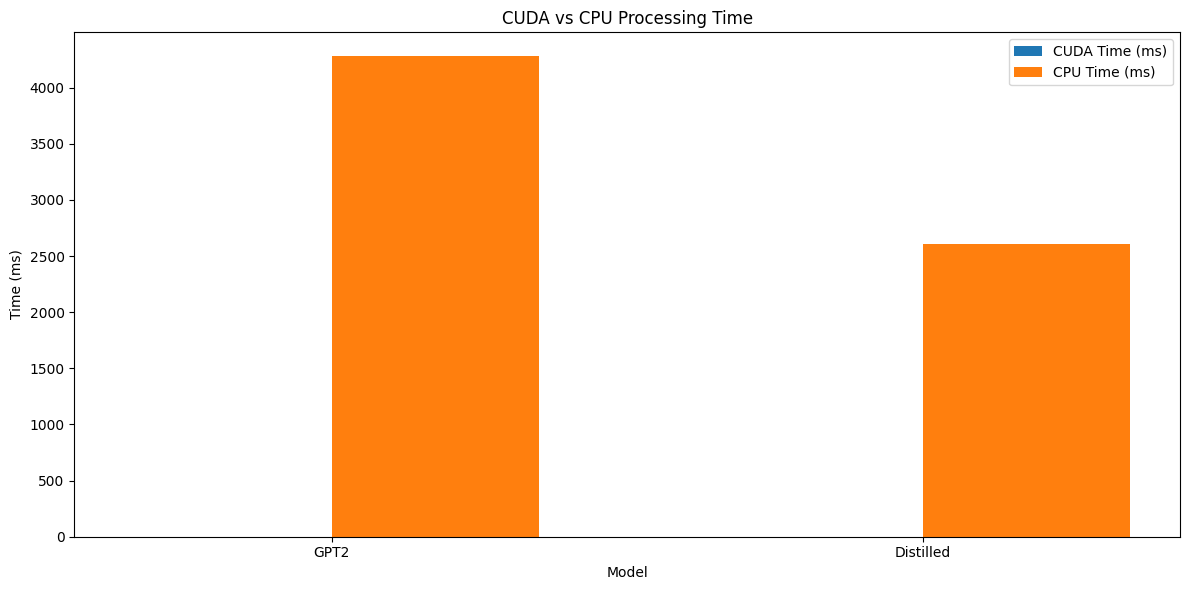

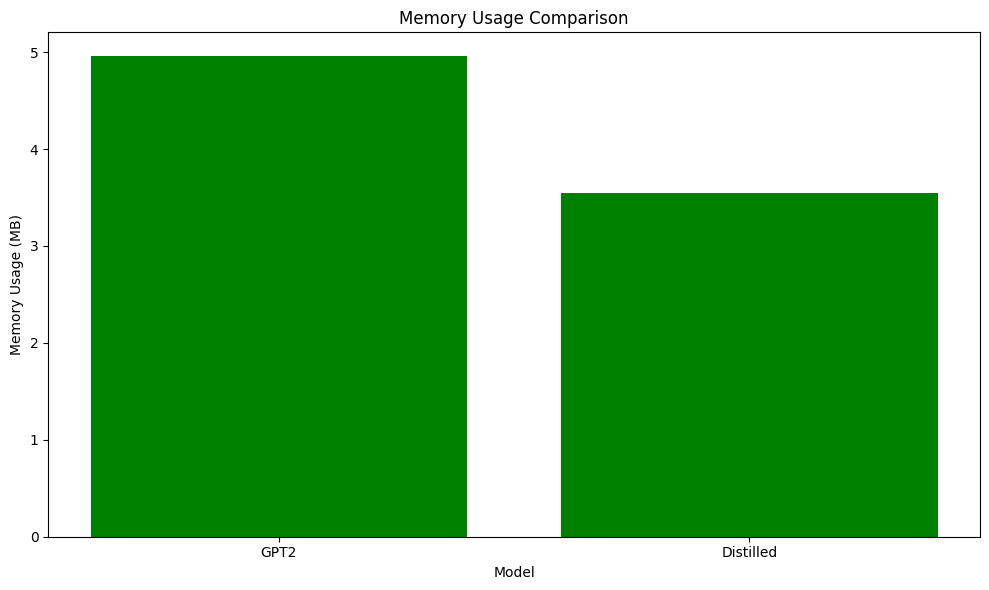

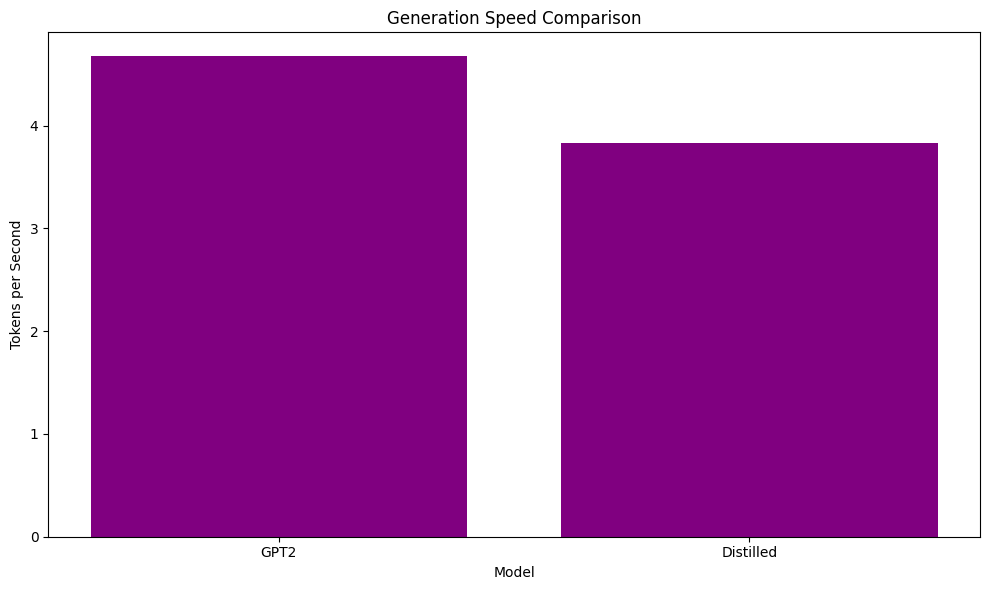

In [26]:
import torch
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import json
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.profiler import profile, record_function, ProfilerActivity

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

models_to_test = {
    "GPT2": "gpt2",
    "Distilled": "./saved_models/distilled_lora_prepruned"
}

prompt = "The future of artificial intelligence in medicine is"
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"
inputs = tokenizer(prompt, return_tensors="pt", padding=True).to(device)

gen_config = {
    "max_new_tokens": 20,
    "pad_token_id": tokenizer.eos_token_id
}

performance_data = {
    "model": [],
    "cuda_time_ms": [],
    "cpu_time_ms": [],
    "memory_usage_mb": [],
    "tokens_per_second": [],
    "input_tokens": [],
    "output_tokens": []
}

def profile_model(model_name, model_path):
    print(f"\n>>> Profiling model: {model_name}")

    start_load = time.time()
    model = AutoModelForCausalLM.from_pretrained(model_path).to(device)
    load_time = time.time() - start_load
    print(f"Model load time: {load_time:.2f} seconds")

    if model_name == "Distilled" and hasattr(model, "use_flash_attention"):
        model.use_flash_attention = True

    model.eval()

    model_size_params = sum(p.numel() for p in model.parameters())
    model_size_mb = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024)
    print(f"Model parameters: {model_size_params:,}")
    print(f"Model size: {model_size_mb:.2f} MB")

    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()
        start_mem = torch.cuda.memory_allocated() / (1024 * 1024)

    start_time = time.time()
    trace_dir = f"./tb_logs/{model_name}"
    os.makedirs(trace_dir, exist_ok=True)

    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        record_shapes=True,
        profile_memory=True,
        with_stack=True
    ) as prof:
        with torch.no_grad():
            with record_function("model_generate"):
                output = model.generate(**inputs, **gen_config)
        # prof.export_chrome_trace(f"{trace_dir}/trace.json")"
        prof.step()

    prof.export_chrome_trace(f"{trace_dir}/trace.json")
    end_time = time.time()
    generation_time = end_time - start_time

    input_token_count = inputs["input_ids"].size(1)
    output_token_count = output.size(1)
    new_tokens = output_token_count - input_token_count
    tokens_per_second = new_tokens / generation_time

    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    print(f"Generated text: {generated_text}")
    print(f"Generation time: {generation_time:.4f} seconds")
    print(f"Tokens per second: {tokens_per_second:.2f}")

    if torch.cuda.is_available():
        end_mem = torch.cuda.max_memory_allocated() / (1024 * 1024)
        memory_used = end_mem - start_mem
        print(f"CUDA memory used: {memory_used:.2f} MB")
    else:
        memory_used = 0

    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

    try:
        avg = prof.key_averages().total_average()
        cuda_time = avg.cuda_time_total / 1000
        cpu_time = avg.cpu_time_total / 1000
    except:
        cuda_time = 0
        cpu_time = generation_time * 1000

    performance_data["model"].append(model_name)
    performance_data["cuda_time_ms"].append(cuda_time)
    performance_data["cpu_time_ms"].append(cpu_time)
    performance_data["memory_usage_mb"].append(memory_used)
    performance_data["tokens_per_second"].append(tokens_per_second)
    performance_data["input_tokens"].append(input_token_count)
    performance_data["output_tokens"].append(output_token_count)

    return {
        "model": model_name,
        "load_time": load_time,
        "generation_time": generation_time,
        "tokens_per_second": tokens_per_second,
        "memory_used_mb": memory_used,
        "model_size_mb": model_size_mb,
        "model_params": model_size_params,
        "input_tokens": input_token_count,
        "output_tokens": output_token_count,
        "generated_text": generated_text
    }

# Run profiling
results = []
for name, path in models_to_test.items():
    try:
        result = profile_model(name, path)
        results.append(result)
    except Exception as e:
        print(f"Error profiling {name}: {e}")

df = pd.DataFrame(performance_data)
print("\nPerformance Summary:")
print(df)

df.to_csv("model_performance.csv", index=False)
print("Performance data saved to model_performance.csv")

with open("model_performance_detailed.json", "w") as f:
    json.dump(results, f, indent=2)

# Charts (optional)
os.makedirs("performance_charts", exist_ok=True)

def create_charts():
    x = np.arange(len(df["model"]))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, df["cuda_time_ms"], width, label="CUDA Time (ms)")
    plt.bar(x + width/2, df["cpu_time_ms"], width, label="CPU Time (ms)")
    plt.xlabel("Model")
    plt.ylabel("Time (ms)")
    plt.title("CUDA vs CPU Processing Time")
    plt.xticks(x, df["model"])
    plt.legend()
    plt.tight_layout()
    plt.savefig("performance_charts/time_comparison.png")

    plt.figure(figsize=(10, 6))
    plt.bar(df["model"], df["memory_usage_mb"], color="green")
    plt.xlabel("Model")
    plt.ylabel("Memory Usage (MB)")
    plt.title("Memory Usage Comparison")
    plt.tight_layout()
    plt.savefig("performance_charts/memory_usage.png")

    plt.figure(figsize=(10, 6))
    plt.bar(df["model"], df["tokens_per_second"], color="purple")
    plt.xlabel("Model")
    plt.ylabel("Tokens per Second")
    plt.title("Generation Speed Comparison")
    plt.tight_layout()
    plt.savefig("performance_charts/tokens_per_second.png")

    print("Charts saved to performance_charts/ directory")

create_charts()
print("\nProfiling complete!")
